In [1]:
from google.colab import drive
drive.mount('/content/drive')
import skimage
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd
from PIL import Image
import torch
import torchvision
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import tqdm
from tqdm import tqdm_notebook
os.chdir('/content/drive/My Drive/amit sethi')

ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)

# Data Path
TEST_PATH = 'Datasets/test/'
TRAIN_PATH = 'Datasets/nucleus/'

# Get train and test IDs
test_ids = next(os.walk(TEST_PATH))[1]
train_ids = next(os.walk(TRAIN_PATH))[1]

%matplotlib inline 

# Root directory of the project
torch.cuda.empty_cache()
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "/content/drive/My Drive/amit sethi/logs")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#### Defining Dataset ####

class NucleusDataset(torch.utils.data.Dataset):
  def __init__(self, images, masks, train = True):
    
    self.images = images
    self.masks = masks
    self.train = train


  def transforms(self, image, mask):
    
    if random.random() > 0.5:
      image = TF.hflip(image)
      mask = TF.hflip(mask)

    if random.random() > 0.5:
      image = TF.hflip(image)
      mask = TF.hflip(mask)

    if random.random() > 0.8:
      image = TF.affine(image, 90, (100,100), 1.0, 45.0)
      mask = TF.affine(mask, 90, (100,100), 1.0, 45.0)

    image = TF.to_tensor(image)
    mask = TF.to_tensor(mask)

    return image,mask


  def __len__(self):
    return len(self.images)

  def __getitem__(self,index): 

    image = self.images[index]
    mask = self.masks[index]

    if self.train:
      x,y = self.transforms(image, mask)

    else:
      x = TF.to_tensor(image)
      y = TF.to_tensor(mask)

    return x,y

In [0]:
### utility functions ###

def train_creator(ids, root):
  images = []
  masks = []

  for i in range(len(ids)):

    image_name = root + ids[i] + '/images/' + ids[i] + '.png'
    mask_name = root + ids[i] + '/masks/' + ids[i] + '.png'
    original_image = Image.open(image_name)
    original_mask = Image.open(mask_name)

    width, height = original_image.size
    for i in range(0,height,200):
      for j in range(0,width,200):
        box = (j,i,j+200, i+200)
        image = original_image.crop(box)
        mask = original_mask.crop(box)
        images.append(image)
        masks.append(mask)
    
  return images, masks

def predict(model, dataloader):
  image, masks = next(iter(dataloader))
  length = len(dataloader)
  outputs = model(image.cuda())

  return image,outputs, masks

def show(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [0]:
### Defining UNET Architecture ###
class unet(nn.Module):

  def contracting_block(self, in_channels, out_channels):
    block = nn.Sequential(nn.Conv2d(in_channels,out_channels, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(out_channels),
                          nn.Conv2d(out_channels, out_channels, 3, padding  = 1), nn.ReLU(), nn.BatchNorm2d(out_channels))
    
    return block

  def expansive_block(self, in_channels, mid_channel, out_channels):
    block = nn.Sequential(nn.Conv2d(in_channels, mid_channel, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(mid_channel),
                          nn.Conv2d(mid_channel, mid_channel, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(mid_channel),
                          nn.ConvTranspose2d(mid_channel, out_channels, 3, 2,padding = 1,output_padding = 1))
    return block

  def final_block(self, in_channels, mid_channel, out_channels):
    block = nn.Sequential(nn.Conv2d(in_channels, mid_channel, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(mid_channel),
                          nn.Conv2d(mid_channel, mid_channel, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(mid_channel), 
                          nn.Conv2d(mid_channel, out_channels, 3, padding =1), nn.Sigmoid())
    return block

  def __init__(self, in_channel, out_channel):
    super(unet, self).__init__()

    self.encode1 = self.contracting_block(in_channel, 64)
    self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
    self.encode2 = self.contracting_block(64,128)
    self.maxpool2 = nn.MaxPool2d(2)
    self.encode3 = self.contracting_block(128,256)
    self.maxpool3 = nn.MaxPool2d(2)

    self.bottleneck = self.expansive_block(256,512,256)

    self.decode3 = self.expansive_block(512,256,128)
    self.decode2 = self.expansive_block(256,128,64)
    
    self.final_layer = self.final_block(128,64,out_channel)

  
  def crop_and_concat(self, upsampled, bypass):
      c = (bypass.size()[2] - upsampled.size()[2]) // 2
      bypass = F.pad(bypass, (-c, -c, -c, -c))
      return torch.cat((upsampled, bypass), 1)


  def forward(self,x):
    encode1 = self.encode1(x)
    maxpool1 = self.maxpool1(encode1)
    encode2 = self.encode2(maxpool1)
    maxpool2 = self.maxpool2(encode2)
    encode3 = self.encode3(maxpool2)
    maxpool3 = self.maxpool3(encode3)

    bottleneck = self.bottleneck(maxpool3)

    decode3 = self.crop_and_concat(bottleneck, encode3)
    cat_layer2 = self.decode3(decode3)
    decode2 = self.crop_and_concat(cat_layer2, encode2)
    cat_layer1 = self.decode2(decode2)
    decode1 = self.crop_and_concat(cat_layer1, encode1)
    final = self.final_layer(decode1)

    return final

In [0]:
train_images, train_masks = train_creator(train_ids, TRAIN_PATH)
test_images, test_masks = train_creator(test_ids, TEST_PATH)

train_dataset = NucleusDataset(train_images, train_masks, True)
lengths = [int(len(train_images) * 0.8), int(len(train_images) * 0.2)]
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, lengths)
test_dataset = NucleusDataset(test_images, test_masks, False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 5, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 5, shuffle = False, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 25, shuffle = False, num_workers = 2)

In [0]:
### Training Functions ###

def train(dataloader, model, optimizer, criterion):
  model.train()
  train_losses.append(0)
  progbar = tqdm_notebook(total = len(dataloader), desc = 'UNet Train')


  for i, (inputs,targets) in enumerate(dataloader):
    optimizer.zero_grad()
    
    inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())

    outputs = model(inputs)
    error = criterion(outputs, targets)

    error.backward()
    optimizer.step()

    train_losses[-1] = train_losses[-1] + error.data
    progbar.set_description('Train (loss=%.4f)' % (train_losses[-1]/(i+1)))
    progbar.update(1)

  train_losses[-1] = train_losses[-1]/len(dataloader)


def val(dataloader, model, criterion):
  
  global best_loss
  progbar = tqdm_notebook(total = len(dataloader), desc = 'UNet Val')
  model.eval()

  val_losses.append(0)

  for i, (inputs, targets) in enumerate(dataloader):
    inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())

    outputs = model(inputs)
    error = criterion(outputs, targets)

    val_losses[-1] = val_losses[-1] + error.data
    progbar.set_description('Val (loss = %.4f)' % (train_losses[-1] /(i+1)))
    progbar.update(1)

  val_losses[-1] = val_losses[-1]/(len(dataloader))

  if best_loss > val_losses[-1]:
    best_loss = val_losses[-1]
    print('SAVING....')
    state = {'model' : model}

    torch.save(state, 'monuseg_unet1' + '.ckpt.t7')

In [0]:
checkpoint = torch.load('monuseg_unet1.ckpt.t7')
model = checkpoint['model']

criterion = torch.nn.BCELoss()

train_losses = []
val_losses = []

epochs = 100

lrs = [1e-2, 1e-3, 1e-4, 1e-4, 1e-4]

In [8]:
progbar_1 = tqdm_notebook(total = 100, desc = 'epochs')
best_loss = 1e5

for epoch in range(100):

  if epoch == 0:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[0], momentum = 0.9, weight_decay= 5e-4)

  if epoch == 20:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[1], momentum = 0.9, weight_decay= 5e-4)

  if epoch == 40:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[2], momentum = 0.9, weight_decay= 5e-4)

  if epoch == 60:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[3], momentum = 0.9, weight_decay= 5e-4)

  train(train_loader, model, optimizer, criterion)
  val(val_loader, model, criterion)

  progbar_1.update(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


SAVING....


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type unet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


SAVING....


SAVING....


SAVING....


SAVING....


SAVING....


SAVING....


SAVING....


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 78, in run
    instances = self.get_instances()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 58, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "/usr/lib/python3.6/_weakrefset.py", line 92, in copy
    return self.__class__(self)
  File "/usr/lib/python3.6/_weakrefset.py", line 50, in __init__
    self.update(data)
  File "/usr/lib/python3.6/_weakrefset.py", line 119, in update
    for element in other:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [25]:
checkpoints = torch.load('monuseg_unet1.ckpt.t7')
model = checkpoints['model']

checkpoints = torch.load('monuseg_hrnet1.ckpt.t7')
model1 = checkpoints['model']

AttributeError: ignored

In [24]:
inputs, outputs, masks = predict(model, test_loader)
inputs1, outputs1, masks1 = predict(model1, test_loader)

RuntimeError: ignored

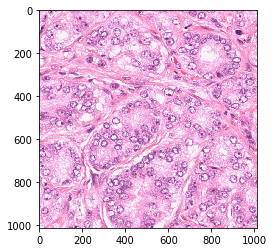

In [19]:
show(torchvision.utils.make_grid(inputs, 5))

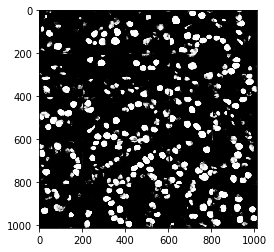

In [23]:
show(torchvision.utils.make_grid(outputs.cpu(), 5))

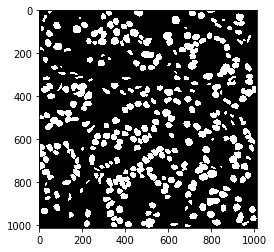

In [22]:
show(torchvision.utils.make_grid(masks, 5))